In [24]:
!pip3 install matplotlib transformers ipywidgets pandas
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [25]:
import csv

filename = 'CommitmentBank-items.csv'
with open(filename, 'r') as f:
    colnames = next(csv.reader(f))

def rows_gen():
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        _ = next(reader)
        for row in reader:
            yield {k: v for k, v in zip(colnames, row)}

## Задача 1

In [26]:
from collections import defaultdict
from typing import Tuple, Dict
predicates = {}
categories = ['modal', 'conditional', 'negation', 'question']
# counting occurances
for r in rows_gen():
    if not r['Verb'] in predicates:
        predicates[r['Verb']] = defaultdict(list)
    for category in categories:
        if category in r['Embedding']:
            predicates[r['Verb']][category].append(float(r['Mean']))
# counting average for each
for p in predicates.keys():
    for c in categories:
        l = len(predicates[p][c])
        if l == 0: 
            del predicates[p][c]
            continue
        predicates[p][c] = (sum(predicates[p][c]) / l, l)
# restructuring data to list of tuples
predicates = [(k, dict(v)) for k, v in predicates.items()]
# filtering out predicates that have less than `treshold` occurences
def enough(predicate: Tuple[str, Dict[str, Tuple[float, int]]]) -> bool:
    treshold = 2
    for _, it in predicate[1].items():
        if it[1] < treshold:
            return False
    return True
print(f"Size before: {len(predicates)};", end=' ')
predicates = [p for p in predicates if enough(p)]
print(f"after: {len(predicates)}")
# sorting by mean modality
predicates.sort(key=lambda x: sum([i[0] for i in x[1].values()]) / len(x[1]))
predicates

Size before: 48; after: 18


[('pretend',
  {'negation': (-1.3958333335, 2),
   'question': (-1.0, 2),
   'modal': (-2.0555555555, 2)}),
 ('seem', {'negation': (-1.292929293, 2)}),
 ('guarantee', {'negation': (-1.0055555555, 2)}),
 ('think',
  {'modal': (0.03923853920512822, 39),
   'negation': (-1.4779347302075474, 265),
   'question': (0.06824805431147542, 61),
   'conditional': (-0.0465858216190476, 21)}),
 ('believe',
  {'negation': (-0.3070549242, 40),
   'conditional': (-0.9083333334000001, 5),
   'question': (-1.1452287581999998, 10),
   'modal': (1.0533625731578946, 19)}),
 ('convince', {'negation': (-0.474877451, 4), 'modal': (0.375, 3)}),
 ('feel',
  {'negation': (-1.4941208965625, 16),
   'question': (-0.060185185166666676, 6),
   'conditional': (0.3854166665, 4),
   'modal': (1.2479166666250001, 8)}),
 ('mean',
  {'negation': (-1.1567053982222224, 27),
   'conditional': (1.0381944445, 4),
   'question': (0.4246031745714286, 7),
   'modal': (0.7994047619285716, 14)}),
 ('decide',
  {'conditional': (-0.1

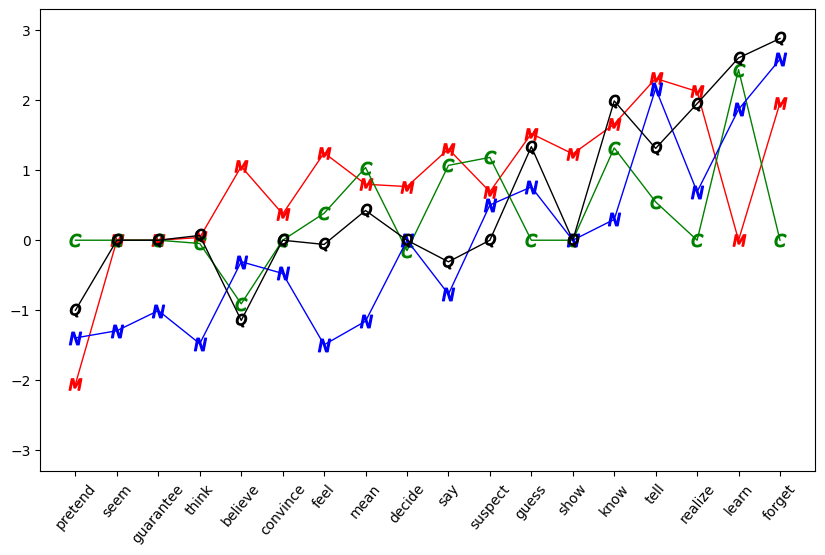

In [27]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,6))
plt.xticks(ticks=[i for i in range(len(predicates))],
           labels=[p[0] for p in predicates],
           rotation=50)
plt.ylim(-3.3, 3.3)

colors = ['r', 'g', 'b', 'black']
markers = ['$M$', '$C$', '$N$', '$Q$']
for cat, col, mar in zip(categories, colors, markers):
    y_data = [it[cat][0] if cat in it else 0 for _, it in predicates]
    plt.plot(y_data, color=col, marker=mar, linewidth=1, markersize=9)

plt.show()

## Задача 2

| Источник | Предикат | Тип | Контекст | Цель | Рейтинг |
|---|---|---|---|---|---|
| НКРЯ \| [Наши дети: Подростки (2004)] | решить | ничего | Но дело в том, что если в книге будет рассказано в таком стиле, вроде сказочных персонажей, объясняющих как и что надо делать, думаю меня ребенок просто засмеет.  Сейчас другие приоритеты. | Он решит, что я свихнулась. | -2 |
| НКРЯ \| [Запись LiveJournal (2004)] | сказать | ничего | Еще сегодня один знакомый из Туниса навел меня на интересную мысль по поводу манер. | Он в разговоре сказал, что всегда открывает девушке дверь машины и помогает сесть, но при этом в душе он ждет, что пока он обходит машину, она изнутри тоже откроет ему дверь, по крайней мере приоткроет. | 2 |
| НКРЯ \| [Андрей Митьков. Мороз по коже. Этап Кубка мира по лыжам в Токсове провели в экстремальных погодных условиях // «Известия», 2003.01.08] | знать | отрицание | Однако на старт в Токсове вышли только три суперзвезды из шести заявленных. | Организаторы не знали, что Бельмондо торжественно проводили из спорта еще весной 2002 года. | 3

## Задача 3

In [28]:
# Preparing NLI dataset
with open('dataset.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(('sentence', 'label'))
    for r in rows_gen():
        mean = float(r['Mean'])
        if mean <= -1: label = 'contradiction'
        elif mean >= 1: label = 'entailment'
        else: label = 'neutral'
        writer.writerow((
            f"{r['Context']} {r['Target']}",
            label
        ))

In [50]:
from transformers import BertTokenizer, BertModel
from torch import nn, argmax, no_grad
import pandas as pd
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset, random_split
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [51]:
num_labels = 3
classifier = nn.Linear(768, num_labels)
model = nn.Sequential(model, classifier)
criterion = nn.CrossEntropyLoss()  
optimizer = AdamW(model.parameters(), lr=2e-5)

In [52]:
class CsvDataSet(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        return self.df.sentence[index], self.df.label[index]
data_set = CsvDataSet('dataset.csv')
train_size = int(0.8 * len(data_set))
test_size = len(data_set) - train_size
train_set, test_set = random_split(data_set, [train_size, test_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(test_size))

  960 training samples
  240 validation samples


In [53]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16)

In [54]:
def train(model, optimizer, train_loader, criterion):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        sentences, labels = batch
        encoded_input = tokenizer(sentences, return_tensors='pt')
        outputs = model(encoded_input)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Training loss: {total_loss/len(train_loader)}')

def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0

    with no_grad():
        for batch in test_loader:
            sentences, labels = batch
            outputs = model(sentences)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predictions = argmax(outputs, dim=1)
            total_acc += (predictions == labels).sum().item()

    print(f'Test loss: {total_loss/len(test_loader)} Test acc: {total_acc/len(test_set)*100}%')

In [59]:
encoded_input = tokenizer("Hello I'm a [MASK] model.", return_tensors='pt')
encoded_input

TypeError: Sequential.forward() got an unexpected keyword argument 'input_ids'

In [55]:
for epoch in range(3):
    train(model, optimizer, train_loader, criterion)
    evaluate(model, test_loader, criterion)

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).